# **Analysis of the role of attention and prompt engineering in decoder-only transformers logical reasoning**

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append("src")
from data_loading import *
from analysis_utils import *


RESULTS_FOLDER = "results"
os.makedirs(RESULTS_FOLDER, exist_ok=True)

### Dataset downloading

In [2]:
DATASET_PATH = "dataset"

if not os.path.isdir(DATASET_PATH):
    !wget -nc -P . https://allenai.org/data/proofwriter
    !unzip -q -d . proofwriter
    !mv proofwriter-dataset-V2020.12.3 $DATASET_PATH
    !rm proofwriter

### Dataset loading

In [3]:
dataset = ProofWriterDataset(None, DATASET_PATH + "/CWA/depth-3/meta-train.jsonl", triple_label="t", rule_label="r")
examples_dataset = ProofWriterDataset(None, DATASET_PATH + "/CWA/depth-3/meta-dev.jsonl", triple_label="t", rule_label="r")

### Model loading

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.random.manual_seed(0)

model_name = "mistralai/Mistral-7B-Instruct-v0.3"

bnb_config = BitsAndBytesConfig(
    # load_in_4bit=True,
    # bnb_4bit_compute_dtype="float16",
    # bnb_4bit_use_double_quant=True,
    # bnb_4bit_quant_type="nf4"
    load_in_8bit=True,
    bnb_8bit_compute_dtype="float16",
    bnb_8bit_use_double_quant=True,
    bnb_8bit_quant_type="nf8"
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    torch_dtype=torch.float16,
    # torch_dtype="auto",
    trust_remote_code=True,
    attn_implementation="eager"
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = "eos_token_id"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Experiments

In [6]:
N_PROMPTS = 3000

#### Zero shot

  0%|          | 0/3000 [00:00<?, ?it/s]

pos ground truth: 1500
neg ground truth: 1500 

  accuracy: 0.52
  f1 score: 0.549
      prec: 0.517
       rec: 0.585


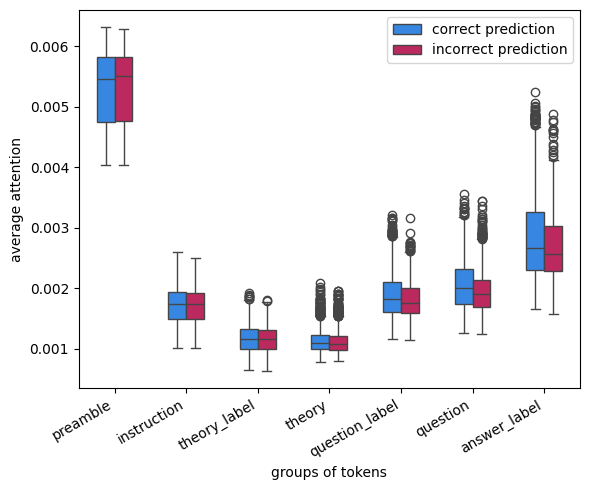

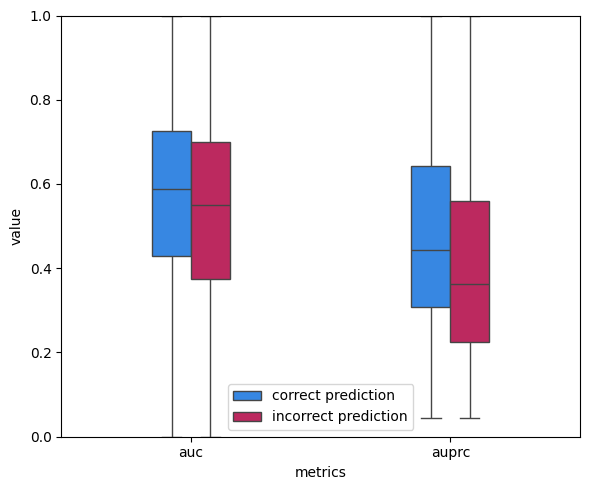

In [7]:
prompts, y_true, proofs = create_prompts(dataset, n_prompts=N_PROMPTS)
text_generation_and_attention_analysis(prompts, y_true, proofs, model, tokenizer, "zero_shot", RESULTS_FOLDER)

#### One shot

  0%|          | 0/3000 [00:00<?, ?it/s]

pos ground truth: 1500
neg ground truth: 1500 

  accuracy: 0.555
  f1 score: 0.598
      prec: 0.545
       rec: 0.662


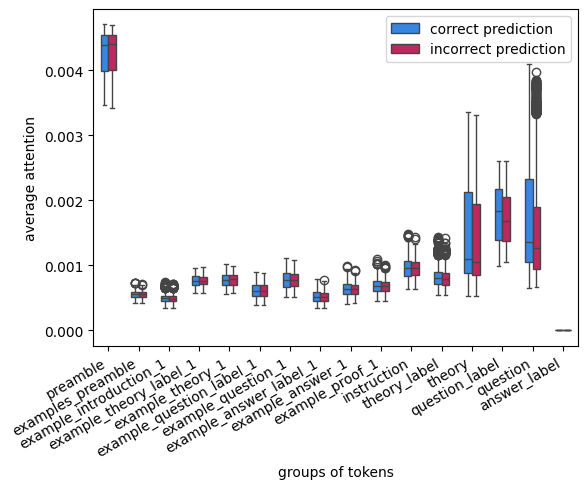

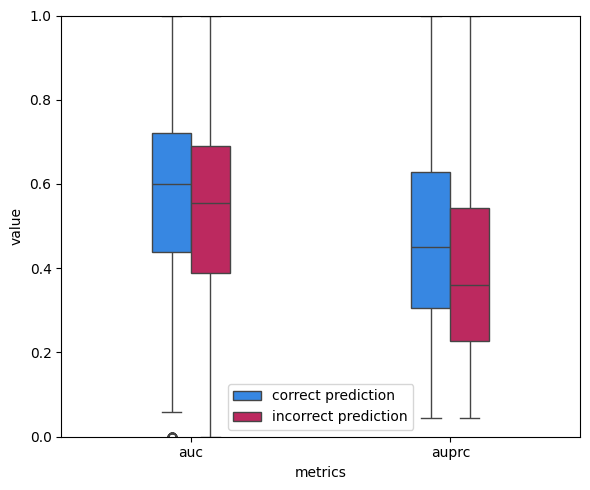

In [8]:
examples = [examples_dataset[12]] #[(i, e) for i, e in enumerate(examples_dataset) if i < 20]
prompts, y_true, proofs = create_prompts(dataset, examples, N_PROMPTS)
text_generation_and_attention_analysis(prompts, y_true, proofs, model, tokenizer, "one_shot", RESULTS_FOLDER)

#### Few shots

  0%|          | 0/3000 [00:00<?, ?it/s]

pos ground truth: 1500
neg ground truth: 1500 

  accuracy: 0.571
  f1 score: 0.599
      prec: 0.563
       rec: 0.639


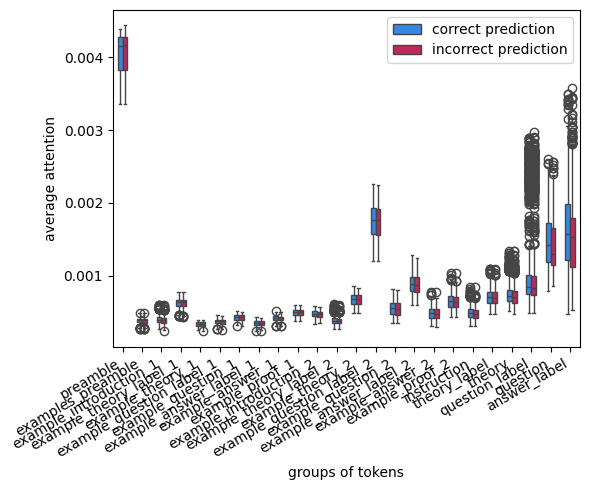

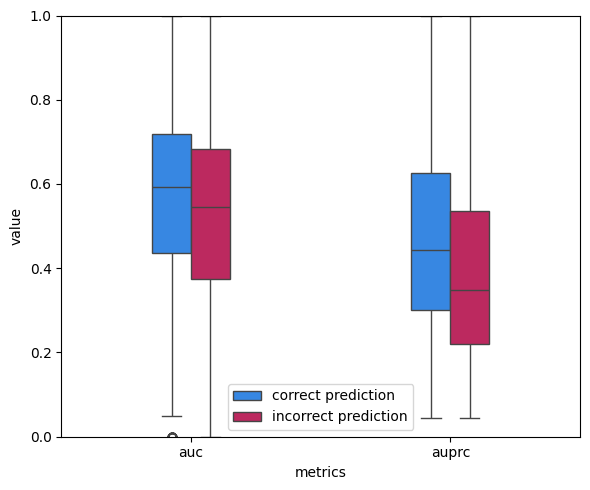

In [9]:
examples = [examples_dataset[9], examples_dataset[12]]
text_generation_and_attention_analysis(*create_prompts(dataset, examples, N_PROMPTS), model, tokenizer, "few_shot", RESULTS_FOLDER)